In [295]:
import IPython, IPython.display
import numpy, PIL
import cStringIO
import scipy.ndimage
import scipy.misc
import matplotlib
import matplotlib.image

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

def fimg_ar_as_PIL(img_ar):
    return PIL.Image.fromarray(numpy.uint8(img_ar))
def fimg_PIL_as_ar(img_pil):
    return numpy.array(img_pil)
def fimg_ar_disp_IPython(img_ar):
    io = cStringIO.StringIO()
    fimg_ar_as_PIL(img_ar).save(io, 'bmp')
    IPython.display.display(IPython.display.Image(data=io.getvalue()))
def fimg_ar_disp(img_ar):
    fimg_ar_disp_IPython(img_ar)
def fimg_load_ar(img_path):
    return matplotlib.image.imread(img_path)
def fimg_ar_size(img_ar):
    return (len(img_ar[0]) if img_ar is not None and len(img_ar) else 0.0, len(img_ar) if img_ar is not None else 0.0)
def fimg_ar_racoon():
    return scipy.misc.face()
def fimg_ar_resize(img_ar, scl):
    return scipy.ndimage.zoom(img_ar, (scl[0],scl[1],1))
def fimg_filled(img_sz, color_val = 0):
    img = np.zeros([img_sz[0],img_sz[1],3],dtype=np.uint8)
    if color_val != 0:
        img.fill(color_val)
    return img

%matplotlib inline
g_has_matplotlib_anim = matplotlib.__version__ > '1.5.0'
if g_has_matplotlib_anim:
    import matplotlib.pyplot as plt
    import matplotlib.animation
    from IPython.display import HTML
    
def fimg_animate_plt(imgs, interval=50):
    if not g_has_matplotlib_anim:
        return None
    def updatefig(frame, ctx, *args):
        ctx['img_i'] = (ctx['img_i'] + 1) % len(ctx['imgs'])
        ctx['im'].set_array(ctx['imgs'][ctx['img_i']])
        return im,
    fig = plt.figure()
    im = plt.imshow(imgs[0], animated=True)
    ctx = {'im':im, 'img_i':0, 'imgs':imgs}
    anim = matplotlib.animation.FuncAnimation(fig, updatefig, interval=interval, blit=True, frames = len(imgs), fargs=(ctx, None))
    return anim
def test_fimg_animate_plt():
    def f(x, y):
        return np.sin(x) + np.cos(y)
    x = np.linspace(0, 2 * np.pi, 120)
    y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
    return fimg_animate_plt( [f(x, y), f(x,y)]*20 )
#HTML(test_fimg_animate_plt().to_html5_video())

In [296]:
import numpy as np

g_pinhole_f = 0.1
g_pinhole_sensor_sz = [0.1,0.1]
g_pihole_img_sz = [256,256]

def fpinhole_matrix(focal):
    return [[-focal, 0, 0],
            [0, -focal, 0],
            [0, 0, 1]]
def fpinhole_viewp(sensor_sz, img_sz):
    return [[img_sz[0]/sensor_sz[0], 0, img_sz[0]/2.0],
            [0, -img_sz[1]/sensor_sz[1], img_sz[1]/2.0],
            [0, 0, 1]]
def fpinhole_pin_pt(pin_mat, pt):
    homog = np.dot(pin_mat, pt)
    #print pt, homog
    return [homog[0]/homog[2], homog[1]/homog[2]]
def fpinhole_viewp_pt(viewp_mat, pt):
    viewp_pt = np.dot(viewp_mat, list(pt)+[1.0])
    return viewp_pt[0:2]
def fpinhole_project_img(pin_mat, viewp_mat, pts, img, pt_colors=[255,255,255]):
    img_sz = fimg_ar_size(img)
    for i_pt, pt in enumerate(pts):
        pin_pt = fpinhole_pin_pt(pin_mat, pt)
        img_pt = [int(x+0.5) for x in fpinhole_viewp_pt(viewp_mat, pin_pt)]
        #print img_pt
        if all([img_pt[i] >= 0 and img_pt[i] < img_sz[i] for i in range(2)]):
            img[img_pt[1]][img_pt[0]] = pt_colors[i_pt if i_pt < len(pt_colors) else 0]
def fpinhole_good_offset(focal, sensor_sz, rad):
    return -rad - max(focal, (focal * rad / (0.5 * min(sensor_sz)))) 
def ftest_pinhole():
    pin_img = fimg_filled(g_pihole_img_sz)
    pin_mat = fpinhole_matrix(g_pinhole_f)
    viewp_mat = fpinhole_viewp(g_pinhole_sensor_sz, g_pihole_img_sz)
    f = -g_pinhole_f
    pts = [ [0, 0, 2*f], 
           [-f/2,-f/2,2*f], [-f/2,f/2,2*f] , [f/2,f/2,2*f], [f/2,-f/2,2*f], 
           [-f/2,-f/2,3*f], [-f/2,f/2,3*f] , [f/2,f/2,3*f], [f/2,-f/2,3*f]
          ]
    pt_cols = [[255,255,255], [255,0,0], [0,0,255]]
    fpinhole_project_img(pin_mat, viewp_mat, pts, pin_img, pt_cols)
    fimg_ar_disp(pin_img)
#ftest_pinhole()

In [297]:
import re

def _fread_obj_vertices_str(obj_str):
    regex = r"^v\s(-?(0|[1-9]\d*)(\.\d+)?)\s(-?(0|[1-9]\d*)(\.\d+)?)\s(-?(0|[1-9]\d*)(\.\d+)?)"
    matches = re.finditer(regex, obj_str, re.MULTILINE)
    verts = []
    for i, match in enumerate(matches):
        verts.append([float(match.groups()[i]) for i in [0,3,6]])
    return verts
def fread_obj_vertices_str(obj_str):
    regex = r"^v\s(.+)\s(.+)\s(.+)"
    matches = re.finditer(regex, obj_str, re.MULTILINE)
    verts = []
    for i, match in enumerate(matches):
        verts.append([float(match.groups()[i]) for i in [0,1,2]])
    return verts
def fread_obj_vertices_file(file):
    verts = []
    with open(file) as fi:
        for line in fi:
            verts.extend(fread_obj_vertices_str(line))
    return verts
def ftest_obj():
    print fread_obj_vertices_file('./data/suzanne.obj')
def fbox_vertices(verts):
    box_max = reduce(lambda a,b: np.maximum(a,b), verts)
    box_min = reduce(lambda a,b: np.minimum(a,b), verts)
    return box_min, box_max
def fcenter_vertices(verts):
    box_min, box_max = fbox_vertices(verts)
    box_cent = 0.5*np.add(box_max, box_min)
    return [np.subtract(x, box_cent) for x in verts]
def frad_vertices(verts):
    box_min, box_max = fbox_vertices(verts)
    return max(np.maximum(np.absolute(box_min), np.absolute(box_max)))
def fpinhole_adjust_vertices(focal, sensor_sz, verts, adjust_zoom = 1.0):
    verts = fcenter_vertices(verts)
    off_z = fpinhole_good_offset(focal, sensor_sz, adjust_zoom * frad_vertices(verts))
    return [x + [0.0, 0.0, off_z] for x in verts]
def frender_verts_img(verts, adjust = False, adjust_zoom = 1.0, focal = g_pinhole_f, sensor_sz = g_pinhole_sensor_sz, img_sz = g_pihole_img_sz):
    pin_img = fimg_filled(img_sz)
    pin_mat = fpinhole_matrix(focal)
    viewp_mat = fpinhole_viewp(sensor_sz, img_sz)
    if adjust:
        verts = fpinhole_adjust_vertices(focal, sensor_sz, verts, adjust_zoom)
    fpinhole_project_img(pin_mat, viewp_mat, verts, pin_img)
    return pin_img
def frender_model_img(filename = './data/bunny.obj', adjust = True, adjust_zoom = 1.0, focal = g_pinhole_f, sensor_sz = g_pinhole_sensor_sz, img_sz = g_pihole_img_sz):
    return frender_verts_img(fread_obj_vertices_file(filename), adjust, adjust_zoom, focal, sensor_sz, img_sz)
#ftest_obj()

In [299]:
#fimg_ar_disp(frender_model_img())

In [300]:
import math

def faxisang_mat(axis, theta):
    axis = np.asarray(axis)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

In [320]:
def flanelet_gen_verts(dims = [0, 1], wh=[0.15, 0.3]):
    verts = np.zeros((4,3))
    verts[0][dimx] = -wh[0]/2; verts[1][dimx] = wh[0]/2; verts[2][dimx] = wh[0]/2; verts[3][dimx] = -wh[0]/2;
    verts[0][dimy] = 0.0; verts[1][dimy] = 0.0; verts[2][dimy] = wh[1]; verts[3][dimy] = wh[1];
    return verts
def flanelet_gen_verts2(pos, dir, up, wh=[0.15, 0.3]):
    arm = np.cross(dir, up); arm = arm / np.linalg.norm(arm);
    base =  [np.add(pos, np.multiply(arm, -wh[0]/2)), np.add(pos, np.multiply(arm, wh[0]/2))]
    return base + [np.add(base[1], dir), np.add(base[0], dir)]
#fimg_ar_disp(frender_verts_img(fstrip_gen_verts(), adjust = True, adjust_zoom = 3.0))

def test_lanelet_render_anim():
    orig_verts = flanelet_gen_verts()
    axis = [1,0,0]
    imgs = []
    for th in range(0, 90, 10):
        mat = faxisang_mat(axis, th*np.pi/180)
        verts = [np.dot(mat, x) for x in orig_verts]
        imgs.append(frender_verts_img(verts, adjust = True, adjust_zoom = 3.0))
        #fimg_ar_disp(imgs[-1])
    return fimg_animate_plt(imgs)
    
#HTML(test_strip_render_anim().to_html5_video())

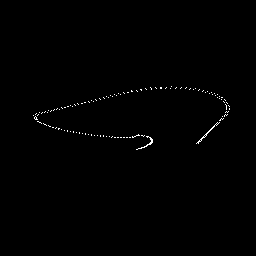

In [371]:
def flane_gen_traj(cmds, dt = 1.0/10, speed = 'ms'):
    kmh2ms = lambda x: x*1000.0/(60.0*60.0)
    ms2ms = lambda x: x
    def dir(pt1, pt2):
        vec = np.subtract(pt2, pt1); return vec / np.linalg.norm(vec)
    def rot_mat(th):
        return [[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]]
    conv_speed = kmh2ms if speed == 'kmh' else ms2ms
    traj = [[0.0, 0.0]]; traj_dir = [[0.0, 1.0]]
    for cmd in cmds:
        ticks = int(cmd['dt'] / dt)
        for tick in range(ticks):
            interp = float(tick)/ticks
            speed = conv_speed( (1-interp) * cmd['speed0'] + interp * cmd.get('speed1', cmd['speed0']) )
            dist = speed*dt
            rad = (1-interp) * cmd.get('rad0', 0.0) + interp * cmd.get('rad1', cmd.get('rad0', 0.0))
            if rad != 0.0:
                rad_angle = max(min(dist / rad, np.pi/2), -np.pi/2)
                rad_arm = [-traj_dir[-1][1]*rad, traj_dir[-1][0]*rad]
                rad_center = np.add(traj[-1],  rad_arm)
                rad_vec = np.subtract(traj[-1], rad_center)
                rad_nvec = np.dot(rot_mat(rad_angle), rad_vec)
                npt = np.add(rad_center, rad_nvec)
                ndir = ([-rad_nvec[1], rad_nvec[0]] / (np.linalg.norm(rad_nvec) * (rad/np.abs(rad)) ))
            else:
                npt = np.add(traj[-1], np.multiply(traj_dir[-1], dist))
                ndir = traj_dir[-1]
            traj.append(list(npt)); traj_dir.append(list(ndir))
    return traj    
def flane_gen_traj1():
    return flane_gen_traj([{'dt':2, 'speed0':0, 'speed1':30},
                           {'dt':1.0, 'speed0':30, 'speed1':45, 'rad0':5},
                           {'dt':0.5, 'speed0':45, 'speed1':60},
                           {'dt':1.0, 'speed0':60, 'speed1':15, 'rad0':0, 'rad1':20},
                           {'dt':1.0, 'speed0':15, 'speed1':60, 'rad0':5, 'rad1':-8},
                          ], dt = 1.0/20, speed = 'kmh')
def flane_plot_traj(traj, show_points = False):
    marker = 'bo-' if show_points else 'b-'
    for i in range(len(traj)-1):
        plt.plot([traj[i][0], traj[i+1][0]], [traj[i][1], traj[i+1][1]], marker, ms=4.0, markerfacecolor='none')
    plt.axis('equal'); plt.show();
def flane_traj_to_lanelets(traj, dims = [0, 1], wh=[0.15, 0.3]):
    def to3d(x): ret = [0.0, 0.0, 0.0]; ret[dims[0]] = x[0]; ret[dims[1]] = x[1]; return ret;
    base_pts = []
    i = 0
    while i < len(traj):
        if len(base_pts) == 0:
            base_pts.append(traj[i]); i = i+1;
        else:
            dist = np.linalg.norm(np.subtract(traj[i], base_pts[-1]))
            if dist >= wh[1]:
                step = np.subtract(traj[i], base_pts[-1]); step = step / np.linalg.norm(step); step = np.multiply(step, wh[1]);
                base_pt0 = base_pts[-1]
                npt = np.add(base_pts[-1], step)
                while np.linalg.norm(np.subtract(npt, base_pt0)) <= dist:
                    base_pts.append(npt); npt = np.add(base_pts[-1], step);
            else:
                i = i+1
    up = [0.0, 0.0, 0.0]; up[3-dims[0]-dims[1]] = 1.0;
    lanelets = []
    for i in range(len(base_pts)-1):
        pt0 = base_pts[i]; pt1 = base_pts[i+1]
        lanelets.append(flanelet_gen_verts2(to3d(pt0), to3d(np.subtract(pt1, pt0)), up, wh))
    return lanelets
def test_flane_gen_traj():
    if False:
        print flane_gen_traj([{'dt':2, 'speed0':15}], 2.0)
        print flane_gen_traj([{'dt':2, 'speed0':15, 'speed1':15}], 1.0)
        print flane_gen_traj([{'dt':2, 'speed0':15, 'speed1':30}], 1.0)
        print flane_gen_traj([{'dt':2, 'speed0':15, 'rad0':5}], 2.0)
        traj = flane_gen_traj([{'dt':1.8, 'speed0':15, 'rad0':5, 'rad1':3}])
        for i in range(len(traj)-1):
            plt.plot([traj[i][0], traj[i+1][0]], [traj[i][1], traj[i+1][1]], 'b' )
        plt.axis('equal'); plt.show();       
    flane_plot_traj(flane_gen_traj1())
def test_flane_traj_to_lanelets():
    dims = [0,1]
    lanelets = flane_traj_to_lanelets(flane_gen_traj1(), dims)
    x = []; y = [];
    for lanelet in lanelets[:]:
        for pt in lanelet:
            x.append(pt[dims[0]]); y.append(pt[dims[1]]);
    plt.scatter(x,y, 0.3, marker='o'); plt.axis('equal'); plt.show();
def test_flane_traj_to_lanelets_render():
    dims = [0,1]
    lanelets = flane_traj_to_lanelets(flane_gen_traj1(), dims)
    lanelet_verts = []
    for lanelet in lanelets[:]:
        for vert in lanelet:
            lanelet_verts.append(vert)
    rot_mat = faxisang_mat([1.0, 0.0, 0.0], np.pi/2 * 0.8)
    lanelet_verts = [np.dot(rot_mat, x) for x in lanelet_verts]
    fimg_ar_disp(frender_verts_img(lanelet_verts, adjust = True, adjust_zoom = 1.0))
#test_flane_gen_traj()
#test_flane_traj_to_lanelets()
test_flane_traj_to_lanelets_render()